## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

from sklearn.utils import shuffle
import os,glob,cv2
import sys,argparse

import random


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Datasets preprocessing 

The dataset is expected to be foldered as something like 'gender/train/male' and '/gender/train/female and 
the same to the test sets

In [2]:
def label_image(gender_field):
    if gender_field == "female":
        label = [1, 0]
    else :
        label = [0, 1]

    return label
def load_data(data_path, image_size, classes):
    train_images = []
    train_labels = []
    
    test_images = []
    test_labels = []
    
    if ('/train' in data_path):
        for gender_field in classes:   
            path = os.path.join(data_path, gender_field, '*.jpg')

            files = glob.glob(path)

            for fl in files:
                image = cv2.imread(fl, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (image_size, image_size))
                image = image.astype(np.float32)

                # Standardize data to have feature values between 0 and 1. 
                # To do this flatten the data first and divide by 255, or Use elementwise product(no flattening)
                image = np.multiply(image, 1.0 / 255.0)

                train_images.append(image)
                
                label = label_image(gender_field)
                
                train_labels.append(label)
        train_images = np.array(train_images)
        train_labels = np.array(train_labels)

        return train_images, train_labels
    
    elif ('/test' in data_path):
        for gender_field in classes:   
            path = os.path.join(data_path, gender_field, '*.jpg')

            files = glob.glob(path)

            for fl in files:
                image = cv2.imread(fl, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (image_size, image_size))
                image = image.astype(np.float32)

                # Standardize data to have feature values between 0 and 1. 
                # Flatten the data first and divide by 255, or use elementwise product(no flattening)
                image = np.multiply(image, 1.0 / 255.0)

                test_images.append(image)

                label = label_image(gender_field)
                test_labels.append(label)

        test_images = np.array(test_images)
        test_labels = np.array(test_labels)

        return test_images, test_labels
    else:
        return None

In [3]:
class ImageDataSet(object):
    def __init__(self, images, image_labels):
        self._num_images = images.shape[0]

        self._images = images
        self._image_labels = image_labels
        self._epochs_done = 0
        self._index_in_epoch = 0
    
    @property
    def images(self):
        return self._images

#     def reshape(self, images):
#         for image in images:
#             np.reshape(image, (image.shape[1] * image.shape[1]))
    
    @property
    def labels(self):
        return self._image_labels

    @property
    def num_examples(self):
        return self._num_images

    @property
    def epochs_done(self):
        return self._epochs_done

    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_images:
            self._epochs_done += 1
            start = 0
            self._index_in_epoch = batch_size
        assert batch_size <= self._num_images
        end = self._index_in_epoch

        return self._images[start:end], self._image_labels[start:end]

In [4]:
def read_train_sets(train_path, image_size, classes, validation_size):
    train_images, train_labels = load_data(train_path, image_size, classes)
    train_images, train_labels = shuffle(train_images, train_labels)  

    if isinstance(validation_size, float):
        validation_size = int(validation_size * train_images.shape[0])

    validation_images = train_images[:validation_size]
    validation_labels = train_labels[:validation_size]

    train_images = train_images[validation_size:]
    train_labels = train_labels[validation_size:]

    train_sets = ImageDataSet(train_images, train_labels)
    valid_sets = ImageDataSet(validation_images, validation_labels)

    return train_sets, valid_sets

In [5]:
def read_test_sets(test_path, image_size, classes):
    test_images, test_labels = load_data(test_path, image_size, classes)
    test_images, test_labels = shuffle(test_images, test_labels)  

    test_sets = ImageDataSet(test_images, test_labels)
    
    return test_sets

### Dimentions

In [6]:
#make image size 50 * 50
img_size = 50

#Images are stored in one dimentional arrays of this length
image_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays
img_shape = (img_size, img_size)

# Number of color channels
num_channels = 1 #

## Load Image dataset

In [7]:
#Prepare input data
classes = ['female','male']
num_classes = len(classes)

# % of the data will automatically be used for validation
validation_size = 0.2

train_path='Image_dataset/train'
test_path ='Image_dataset/test'

# We shall load all the training and validation images and labels into memory using openCV and use that during training
train_data, valid_data = read_train_sets(train_path, img_size, classes, validation_size=validation_size)
test_data = read_test_sets(test_path, img_size, classes)

print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set : {}".format(len(train_data.labels)))
print("Number of files in Validation-set:{}".format(len(valid_data.labels)))
print("Number of files in Test-set : {}".format(len(test_data.labels)))

Complete reading input data. Will Now print a snippet of it
Number of files in Training-set : 1120
Number of files in Validation-set:280
Number of files in Test-set : 600


In [8]:
# class of each image in the validation set 
# test_data_classes = np.array([label for label in test_data[1]])

# class of each image in the validation set 
test_data_labels = np.array([label for label in test_data.labels])

test_data_cls = np.argmax(test_data_labels, axis=1)

## Plot sample Images and get introduced to the data

In [9]:
#Take random 24 images and see their true label

#Take random 24 images and see their true label

def plot_images(images, cls_true, cls_pred = None):
    assert len(images) == len(cls_true) == 24

    # Create a figure with 4 x 6 subclass
    fig, axes = plt.subplots(4, 6)
    fig.subplots_adjust(hspace = 0.1, wspace = 0.9)
 
    
    for i, ax in enumerate(axes.flat):
        # Plot the image
        ax.imshow(images[i])

        # Show true and predicted classes
        if cls_pred is None:
            xlabel = "{0}".format(classes[cls_true[i]])
        else:
            xlabel = "T:{0}, P:{1}".format(classes[cls_true[i]][0], classes[cls_pred[i]][0])

        ax.set_xlabel(xlabel)

        # Remove ticks from the plot

        ax.set_xticks([])
        ax.set_yticks([])

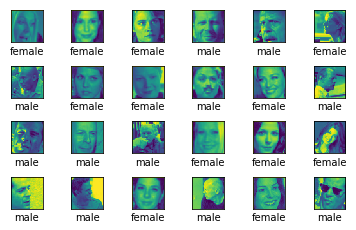

In [10]:
#first 24 images from the train_set
images = test_data.images[:24]

#True classes for images
cls_true = test_data_cls[:24]

# [0, 1] corresponds to femaleness, [male = 0, female] and [1, 0] maleness, [male, female=0] 
plot_images(images = images, cls_true = cls_true)
plt.show()

## Helper Functions to create model variables to be optimized

In [11]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.05))

def new_bias(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

## Convolutional networks

In [12]:
# Convolutional Layer 1
filter_size1 = 5 # concolution filters are 5 x 5 fileters
num_filters1 = 16

# Convolutional Layer 2
filter_size2 = 5
num_filters2 = 36

# Convolutional Layer 3
filter_size3 = 5
num_filters3 = 64

# Convolutional Layer 4
filter_size4 = 5
num_filters4 = 128

# Fully Connected Layer
fc_size = 128 # numbrer of filters in the fully connected layers

In [13]:
def new_conv_layer(input,               # The previous layer
                   num_input_channels,  # Num Channels in prev layer
                   filter_size,         # Width and height of each filter
                   num_filters,         # Number of filters
                   use_pooling=True):   # Use 2x2 max-pooling
    
    # Shape the filter weights 4conv. 
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    
    #create new weights
    weights = new_weights(shape = shape)
    
    # create bisase
    biases = new_bias(length=num_filters)
    
    # Create tensorflow operation for convolution
    # The first and last strides must always set to 1, bc are for image-number and input-channel respectively
    layer = tf.nn.conv2d(input=input,
                         filter=weights, 
                         strides=[1, 1, 1, 1], 
                         padding='SAME') # zero padding
    
    # Add bias to the results of the convolution, to each filter channel
    layer += biases
    
    # Use filter to down sample the image resolution
    if use_pooling:
        # 2x2 max pooling
        layer = tf.nn.max_pool(value=layer, 
                               ksize=[1, 2, 2, 1], 
                               strides=[1, 2, 2, 1], 
                               padding='SAME')
        
    # Rectified Linear Unit, calculates max(x, 0) for each input channel x, => adds some linearity to the formula      
    layer = tf.nn.relu(layer)
    
    # Note ReLU normally excuted before pooling but, relu(max_pool(x) == max_pool(relu(x)))
    
    return layer, weights

In [14]:
def flatten_layer(layer):
    # Get shape of input layer
    layer_shape = layer.get_shape()
    
    #expected 2be layer_shape == [num_images, img_width, img_height, num_channels]
    
    # num_features is img_width * img_height * num_channels
    # Shape uses tensorflow datatype, so convert it to numpy
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features]
    # The first dim is set to -1 wh means the size in that dimension is calculated, so z total size of tensor
    # is unchanged from the reshaping
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

In [15]:
def new_fc_layer(input,       # The previous layer
                 num_inputs,    # num inputs from the prev layer
                 num_outputs,     # num outputs
                 use_relu = True):  # Use relu?
    
    # Create new weights and biases
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_bias(length=num_outputs)
    
    # Calculate the layer
    layer = tf.matmul(input, weights) + biases
    
    # Use relu:
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer

### Placeholder Variables

In [16]:
x = tf.placeholder(tf.float32, shape=[None, image_size_flat], name='x')

# The convolution layer expects x to be encoded as a 4-Dim tensor, so we have to reshape to [m, w, h, nc] 
# Note w == h == img_size, and num_images (m) can be inferred automatically using -1 for size of 1st dim
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])


y_true = tf.placeholder(tf.float32, shape=[None, 2], name='y_true')

y_true_cls = tf.argmax(y_true, axis=1)


In [17]:
x_image

<tf.Tensor 'Reshape:0' shape=(?, 50, 50, 1) dtype=float32>

### Convolution layers

In [18]:
layer_conv1, weights_conv1 = new_conv_layer(input = x_image,
                                            num_input_channels=num_channels, 
                                            filter_size=filter_size1,
                                            num_filters = num_filters1,
                                            use_pooling=True)

In [19]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 25, 25, 16) dtype=float32>

In [20]:
layer_conv2, weights_conv2 = new_conv_layer(input = layer_conv1,
                                            num_input_channels=num_filters1, 
                                            filter_size=filter_size2,
                                            num_filters = num_filters2,
                                            use_pooling=True)

In [21]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 13, 13, 36) dtype=float32>

In [22]:
layer_conv3, weights_conv3 = new_conv_layer(input = layer_conv2,
                                            num_input_channels=num_filters2, 
                                            filter_size=filter_size3,
                                            num_filters = num_filters3,
                                            use_pooling=True)

In [23]:
layer_conv3

<tf.Tensor 'Relu_2:0' shape=(?, 7, 7, 64) dtype=float32>

In [24]:
layer_conv4, weights_conv4 = new_conv_layer(input = layer_conv3,
                                            num_input_channels=num_filters3, 
                                            filter_size=filter_size4,
                                            num_filters = num_filters4,
                                            use_pooling=True)

In [25]:
layer_conv4

<tf.Tensor 'Relu_3:0' shape=(?, 4, 4, 128) dtype=float32>

In [26]:
# Flatten the 4D vector to be used in fully connected layer
layer_flat, num_features = flatten_layer(layer_conv4)

In [27]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 2048) dtype=float32>

In [28]:
num_features

2048

### Fully connected layers

In [29]:
layer_fc1 = new_fc_layer(input = layer_flat,
                        num_inputs = num_features,
                        num_outputs = fc_size,
                        use_relu = True)

In [30]:
layer_fc1

<tf.Tensor 'Relu_4:0' shape=(?, 128) dtype=float32>

In [31]:
# Layer fully connected 2
layer_fc2 = new_fc_layer(input = layer_fc1,
                        num_inputs = fc_size,
                        num_outputs = num_classes,
                        use_relu = False)

In [32]:
layer_fc2

<tf.Tensor 'add_5:0' shape=(?, 2) dtype=float32>

### Predicted classes

In [33]:
y_pred = tf.nn.softmax(layer_fc2,name="y_pred")

y_pred_cls = tf.argmax(y_pred, axis=1)

y_pred_cls

<tf.Tensor 'ArgMax_1:0' shape=(?,) dtype=int64>

In [34]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [35]:
cost = tf.reduce_mean(cross_entropy)

### Optimization Method

In [36]:
optimizer = tf.train.AdadeltaOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measure

In [37]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [38]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create Tensorflow session and Initialize Variables

In [39]:
session = tf.Session()

In [40]:
# Initialize variables
session.run(tf.global_variables_initializer())

## Perform optimization

In [41]:
train_batch_size = 64

a, b = train_data.next_batch(train_batch_size)

a.shape

(64, 50, 50)

In [42]:
b.shape

(64, 2)

In [43]:
def reshape_image(images):
    return np.reshape(images, (images.shape[0], images.shape[1]*images.shape[2]))

In [44]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = train_data.next_batch(train_batch_size)
        
        x_batch_reshaped = reshape_image(x_batch)
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch_reshaped,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [45]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-labels for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = test_data.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = test_data_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:24],
                cls_true=cls_true[0:24],
                cls_pred=cls_pred[0:24])

In [46]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = test_data_cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [56]:
# Split the test-set into smaller batches of this size.
test_batch_size = 32

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(test_data.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = reshape_image(test_data.images[i:j, :])
        
        # Get the associated labels.
        labels = test_data.labels[i:j]
        
        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

#         print(feed_dict)
        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        
#         print(cls_pred[i])

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
    # Convenience variable for the true class-numbers of the test-set.
    cls_true = test_data_cls
    
#     for k in range (10):
#         print(cls_pred[k], cls_true[k])
        
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [57]:
print_test_accuracy()

Accuracy on Test-Set: 47.7% (286 / 600)


In [58]:
optimize(num_iterations=1)

Optimization Iteration:    101, Training Accuracy:  32.8%
Time usage: 0:00:01


In [59]:
print_test_accuracy()

Accuracy on Test-Set: 47.7% (286 / 600)


In [60]:
optimize(num_iterations=99)

Time usage: 0:00:40


Accuracy on Test-Set: 48.0% (288 / 600)
Example errors:


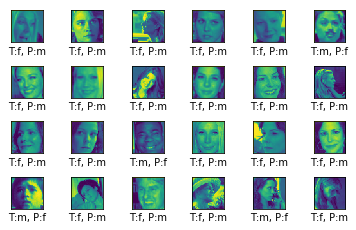

In [61]:
print_test_accuracy(show_example_errors=True)

In [62]:
optimize(num_iterations=900)

Optimization Iteration:    201, Training Accuracy:  43.8%
Optimization Iteration:    301, Training Accuracy:  42.2%
Optimization Iteration:    401, Training Accuracy:  50.0%
Optimization Iteration:    501, Training Accuracy:  51.6%
Optimization Iteration:    601, Training Accuracy:  46.9%
Optimization Iteration:    701, Training Accuracy:  45.3%
Optimization Iteration:    801, Training Accuracy:  54.7%
Optimization Iteration:    901, Training Accuracy:  64.1%
Optimization Iteration:   1001, Training Accuracy:  42.2%
Time usage: 0:06:00


Accuracy on Test-Set: 50.2% (301 / 600)
Example errors:
Confusion Matrix:
[[ 50 250]
 [ 49 251]]


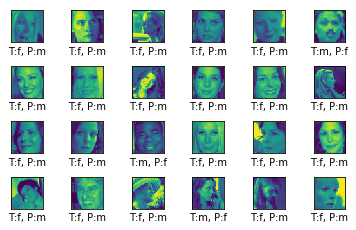

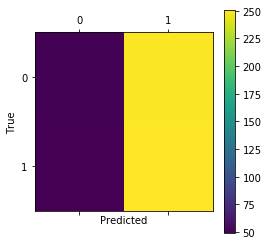

In [64]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

In [65]:
optimize(num_iterations=3000)

Optimization Iteration:   1101, Training Accuracy:  59.4%
Optimization Iteration:   1201, Training Accuracy:  50.0%
Optimization Iteration:   1301, Training Accuracy:  50.0%
Optimization Iteration:   1401, Training Accuracy:  48.4%
Optimization Iteration:   1501, Training Accuracy:  60.9%
Optimization Iteration:   1601, Training Accuracy:  53.1%
Optimization Iteration:   1701, Training Accuracy:  42.2%
Optimization Iteration:   1801, Training Accuracy:  35.9%
Optimization Iteration:   1901, Training Accuracy:  42.2%
Optimization Iteration:   2001, Training Accuracy:  50.0%
Optimization Iteration:   2101, Training Accuracy:  51.6%
Optimization Iteration:   2201, Training Accuracy:  54.7%
Optimization Iteration:   2301, Training Accuracy:  46.9%
Optimization Iteration:   2401, Training Accuracy:  50.0%
Optimization Iteration:   2501, Training Accuracy:  59.4%
Optimization Iteration:   2601, Training Accuracy:  67.2%
Optimization Iteration:   2701, Training Accuracy:  43.8%
Optimization I

Accuracy on Test-Set: 56.8% (341 / 600)
Example errors:
Confusion Matrix:
[[ 63 237]
 [ 22 278]]


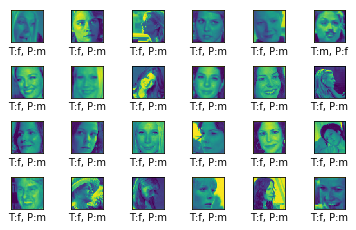

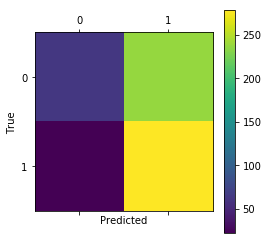

In [66]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)